# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

The aim of this project is to to classify traffic signs in an appropriate categories. The dataset uses the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) with 43 distinct categories.

This project implements the classifer using a deep learning techinique, called convolutional neural network (CNN). The project implemenation is divided in the following steps.

---

## Step 1: Dataset Exploration

As stated earlier, the German Traffic Signs dataset is used. The traffic signs and their labels are pickled is a dictionary with 4 key/value pairs.

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2).

In [32]:
# Import useful packages

from datetime import timedelta
from IPython.display import Image
from PIL import Image
from scipy.stats import itemfreq
from sklearn.cross_validation import train_test_split # model_selection
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
import collections
import cv2
import math
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import time
import warnings
warnings.filterwarnings("ignore")

### Load Traffic Signal Data

Let's first read the pickle file to load training and test features and label data. X_train and X_test refer to features (sign images) while y_train and y_test refer to label (sign name).

In [33]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
directory = "./traffic-signs-data"
training_file = directory + "/train.p"
testing_file = directory + "/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

Now, let's load the data dictionary for sign names and check what does each category refer to.

In [34]:
# Read traffic signal data dictionary
ts_data_dictionary = pd.read_csv("./signnames.csv")
ts_data_dictionary

ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                               Stop
15       15                                        No vechiles
16       16           Vechiles over 3.5 metric tons prohibited
17       17                                           No entry
18       18                                    General caution
19       19                        Dangerous curve to the left
20       20                       Dangerous curve to the right
21       21                                       Double curve
22       22                                         Bumpy road
23       23                                      Slippery road
24       24                          Road narrows on the right
25       25                                          Road work
26       26                                    Traffic signals
27       27                                        Pedestrians
28       28                                  Children crossing
29       29                                  Bicycles crossing
30       30                                 Beware of ice/snow
31       31                              Wild animals crossing
32       32                End of all speed and passing limits
33       33                                   Turn right ahead
34       34                                    Turn left ahead
35       35                                         Ahead only
36       36                               Go straight or right
37       37                                Go straight or left
38       38                                         Keep right
39       39                                          Keep left
40       40                               Roundabout mandatory
41       41                                  End of no passing
42       42  End of no passing by vechiles over 3.5 metric ...

### Statistics

In [35]:
# number of training examples
n_train = len(X_train)

# number of testing examples
n_test = len(X_test)

# shape of an image
image_shape = (X_train[0].shape)

# Number of classes are in the dataset
n_classes = len(np.unique(y_train))

# image size in pixels
imgsize = X_train[0].shape[1]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [36]:
#  Bar chart of traffic sign labels
label_freq = itemfreq(y_train)

def plot_tf_freq(label):
    """Plot frequency of each traffic sign"""
    y_train = label
    label_freq = itemfreq(y_train)
    
    fig = plt.figure(figsize=(8,4))
    plt.bar(label_freq[:,0], label_freq[:,1], align='center', alpha=0.5)
    plt.xlabel("Traffic Sign Labels")
    plt.ylabel("Frequency")
    plt.title("Frequency of Traffic Sign Labels")
    plt.grid(True)
    
    axes = plt.gca()
    axes.set_xlim([-1,44])
    axes.set_ylim([0,2600])
    plt.gcf().set_size_inches(8,4)
    plt.show()
#     fig.savefig("TrafficSignal_Frequency.png")

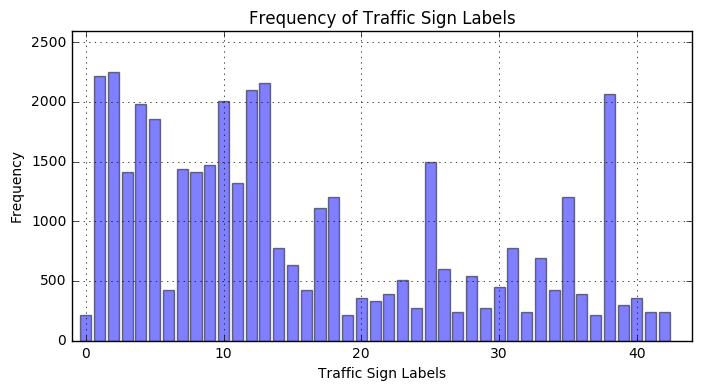

In [37]:
plot_tf_freq(y_train)

In [38]:
# Statistics of the data

label_min = np.min(label_freq[:,1])
label_max = np.max(label_freq[:,1])
label_average = n_train/n_classes

# Calcualate # underrepresented label category below certain thresholds
threshold = 500
num_underrepresented_labels = np.sum(label_freq[:,1] <= threshold)

print("Minimum sample size in a category =", label_min)
print("Maximum sample size in a category =", label_max)
print("Average samples in a category =", label_average)
print("# Under-represented samples below 500 thresold =", num_underrepresented_labels)

Minimum sample size in a category = 210
Maximum sample size in a category = 2250
Average samples in a category = 911.8372093023256
# Under-represented samples below 500 thresold = 19


The statistics and plot indicate that the data is unbalanced across different traffic sign classes. In order to make it a balanced class problem, additional dataset is generated in the next sub-section.

### Plot sample images from each category

In [39]:
# Grid plot images

rows = n_classes
cols = 5

def gridplot_ts(ts_dict, X_train, filename):
    """Plot sample images from each category"""
    
    fig = plt.figure()
    gs1 = gridspec.GridSpec(rows, cols)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
    scaling = 4
    plt.figure(figsize=(1*scaling,9*scaling))
    
    for label in np.arange(rows):
        for i in np.arange(cols):
            ax1 = plt.subplot(gs1[label*cols+i])
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_aspect('equal')
            idx = np.random.choice(ts_dict[label], 1, replace=False)[0] 
    
            plt.subplot(rows,cols,label*cols+i+1)
            plt.imshow(X_train[idx])
            plt.axis('off')
    
    fig.savefig(filename)
    plt.show()

In [40]:
# Build traffic signal dictionary index to find out 
# which image belong to a sign category

ts_dict_index = {}
for numlabel in np.arange(n_classes):
    ts_dict_index[numlabel] = []
    for i in np.where(y_train==numlabel)[0]:
        ts_dict_index[numlabel].append(i)

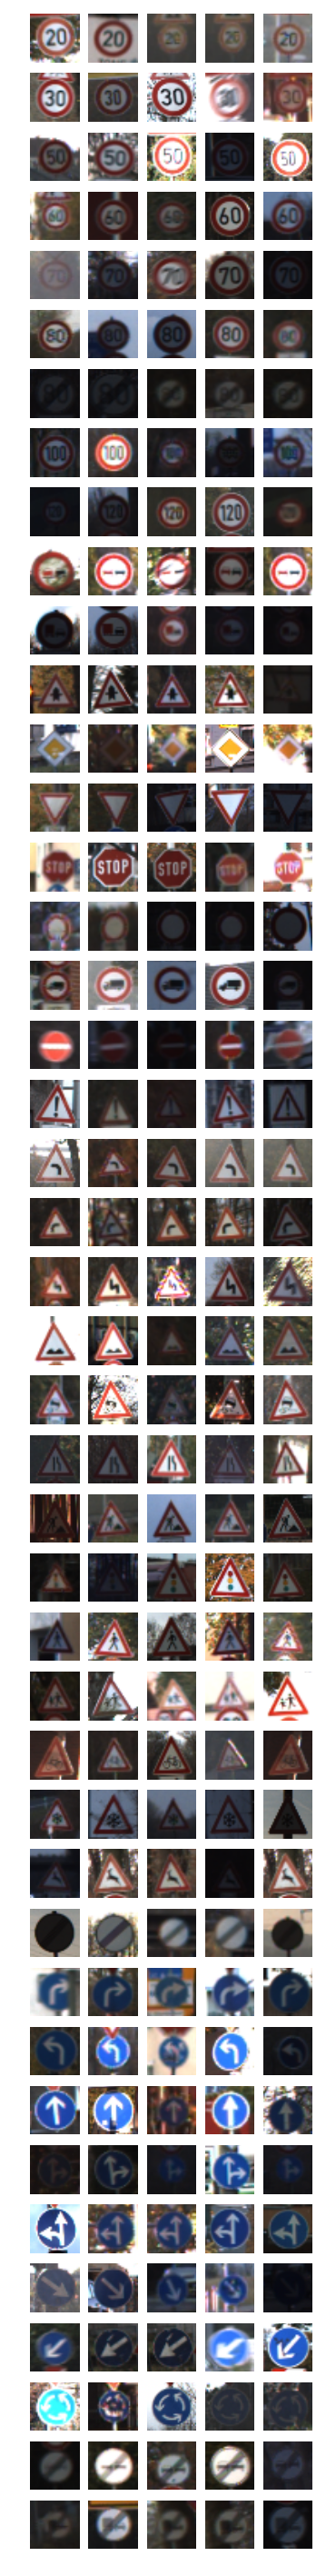

In [10]:
gridplot_ts(ts_dict_index, X_train, "original_ts.png") 

----

## Step 2: Preprocess and Generate New Data


As the data is read, it's time to preprocess the data. Grayscaling and image normalization is performed. In order to overcome the imbalance class problem, additional data is generated from the original training data.  

In particular, grayscale is chosen over RGB space as it averages color pixel information from all the color spaces.     
Image normalization is also an important step to bring the pixel intensities of different images in the threshold [0.0, 1.0] with mean 0.5. This is particularly useful in implementing the same algorithm to different images and in numerical stablilzation.   

In the preprocessing step, images are convered to grayscale and then normalized.   


### Preprocess images (grayscaling and normalization)

In [41]:
#%% Helper Functions

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    To see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
def normalize_image(img):
    """Normalize the image"""
    a = 0
    b = 1
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (img - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )


def img_data_normalization(img_data):
    """Perform greyscaling and normalization of images"""    
    img_data_gray_temp = []
    for i in np.arange(len(img_data)):
        img_data_gray_temp.append(grayscale(img_data[i]))
    
    img_data_gray = np.asarray(img_data_gray_temp)
    img_data_normalized = normalize_image(img_data_gray)
    del img_data_gray_temp, img_data_gray  
    
    return img_data_normalized

In [42]:
# Grayscale and normalize train and test images

X_train_gray = img_data_normalization(X_train)
X_test_gray = img_data_normalization(X_test)
print('Images Preprocessed: Grayscaled and Normalized')

Images Preprocessed: Grayscaled and Normalized


### Preprocess labels (convert to one-hot encoded vector)

In [43]:
# Turn labels into numbers and apply One-Hot Encoding

encoder = LabelBinarizer()
encoder.fit(y_train)

train_labels = encoder.transform(y_train).astype(np.float32)
test_labels = encoder.transform(y_test).astype(np.float32)
print('Labels converted to one-hot encoded vector')

Labels converted to one-hot encoded vector


### Generate Additional Dataset

The additional data is generated from training dataset by randomly picking images and transforming them using translation, angular and shear transformations.  

In [44]:
# Helper function to transform, rotate and shear an image
# Adopted from https://carnd-udacity.atlassian.net/wiki/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

Now, it is a time to figure out how many additional samples are to be generated for each class label. From the frequency graph of labels in the above section, class # 2 (Speed limit (50km/h)) has highest frequency of 2250. Instead of picking the maximum frequency as maximum number of samples in each class, the maximum number of sample in each class is drawn from a normal distribution with mean equal to (2250 + delta), where delta is a number of choice. For the exercise delta is chosen as 250. 

<img src="additionaldata.png">

In [15]:
# Count of new data to be generated in each category 

from scipy.stats import norm
max_data_size = label_max+250
scaling_factor = 25

ts_max_labels = np.rint(norm.rvs(loc = max_data_size, size = n_classes, scale = scaling_factor))
new_data_labels_count = (ts_max_labels - label_freq[:,1])

new_data_mul_factor = (new_data_labels_count/label_freq[:,1])

new_counts = (label_freq[:,1]*new_data_mul_factor)

The frequency for original and generated data is plotted.

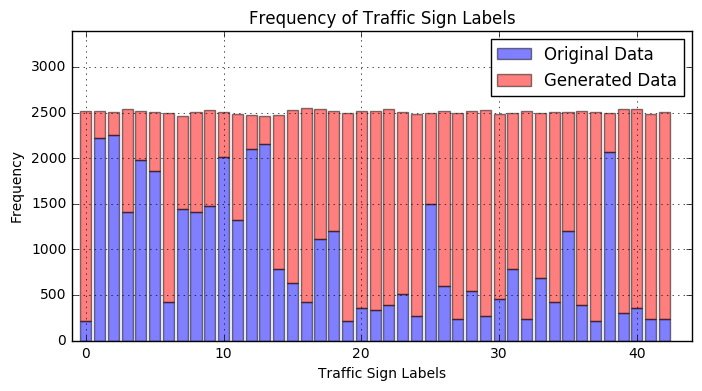

In [16]:
# plot count of original and new data

def plot_new_data(label, new_label):
    x = range(len(label))
    
    fig = plt.figure(figsize=(8,4))
    
    p1= plt.bar(x, label, align='center', alpha=0.5)
    p2 = plt.bar(x, new_label, align='center', alpha=0.5, color='r',
             bottom=label)
    plt.xlabel("Traffic Sign Labels")
    plt.ylabel("Frequency")
    plt.title("Frequency of Traffic Sign Labels")
    plt.grid(True)
    plt.legend((p1[0], p2[0]), ('Original Data', 'Generated Data'))
    
    axes = plt.gca()
    axes.set_xlim([-1,44])
    axes.set_ylim([0,3400])
#     plt.gcf().set_size_inches(8,4)
    plt.show()
    
plot_new_data(itemfreq(y_train)[:,1], new_counts.astype(int))    

Now, we know additional number of dataset to be generated in each class. An image is randomly picked and additional data is generated by using translation, angular and shear transformations on an image. 

In [17]:
#%% Generate additional data - Updated

angle_range = 15
shear_range = 5
translation_range = 5

X_train_temp = X_train
y_train_temp = y_train

new_X_train = X_train_temp
new_y_train = y_train_temp

newts_dict_index = {} #ts_dict_index
inc_index = len(X_train_temp)
threshold = 0.2

for label in np.arange(rows): #rows
    newts_dict_index[label] = []
    
    dummy_array = np.array([np.zeros(X_train_temp[0].shape)])
    dummy_y = np.array([np.zeros(y_train_temp[0].shape)])
    
    for i in np.arange(new_counts[label]): #new_data_labels_count
        idx = np.random.choice(ts_dict_index[label], 1, replace=False)[0]
        img = X_train_temp[idx]

        newimg = transform_image(img,angle_range,shear_range,translation_range)
        dummy_array = np.concatenate((dummy_array,[newimg]))
        dummy_y = np.concatenate((dummy_y,[label]))
        inc_index = inc_index + 1
        newts_dict_index[label].append(inc_index)

    dummy_array = np.delete(dummy_array,0,0)  
    dummy_y = np.delete(dummy_y,0,0)               
    new_X_train = np.concatenate((new_X_train,dummy_array))
    new_y_train = np.concatenate((new_y_train,dummy_y))   
    
print(">>>>> New Data generation Completed.")         

>>>>> New Data generation Completed.


Randomly seleted samples of additional dataset is plotted below.

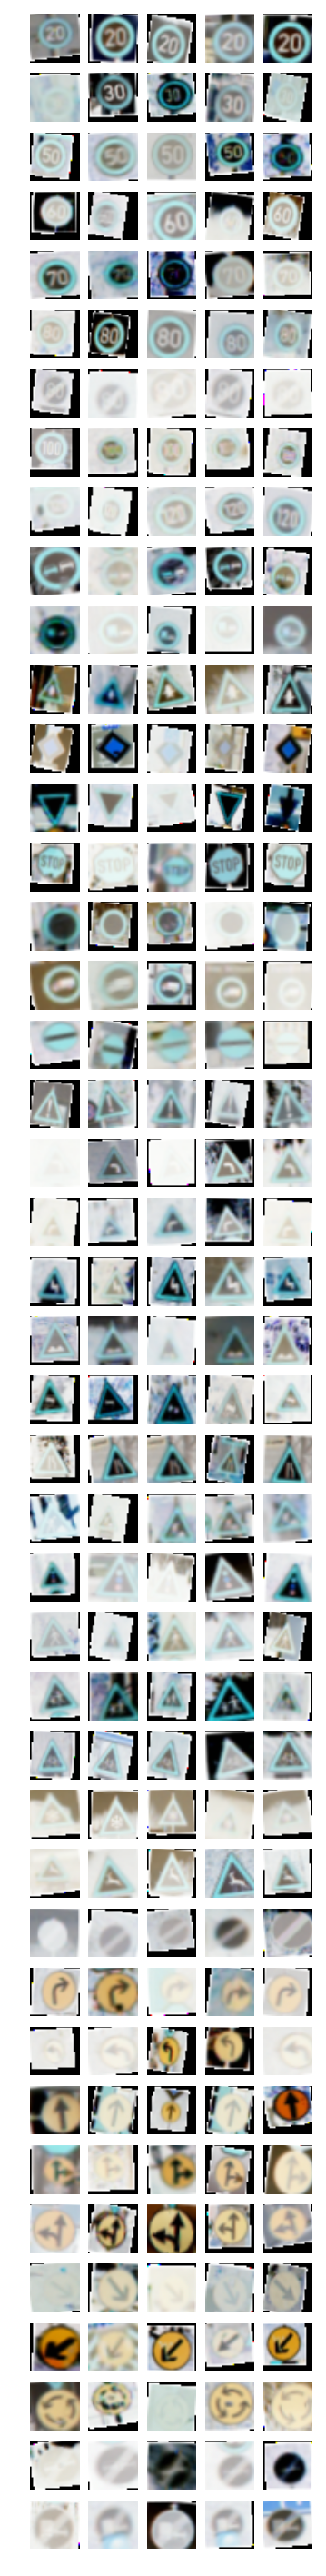

In [18]:
# Plot sample generated images
gridplot_ts(newts_dict_index, new_X_train, "new_ts.png") 

--------------
## Generate Training, Validation and Test Datasets

In [45]:
# Convert images to float32 and grayscale and normalize the images

new_X_train = np.array(new_X_train, dtype=np.float32)
new_y_train = np.array(new_y_train, dtype=np.float32)
new_X_train_gray = img_data_normalization(new_X_train)

NameError: name 'new_X_train' is not defined

In [46]:
# Get randomized datasets for training, validation and test

train_features, valid_features, train_labels, valid_labels = train_test_split(
    new_X_train_gray,
    new_y_train,
    test_size=0.1,
    random_state=832289)

test_features = X_test_gray
test_labels = y_test

print('Training features and labels randomized and split.')

NameError: name 'new_X_train_gray' is not defined

In [21]:
freq_train = itemfreq(train_labels)[:,1]

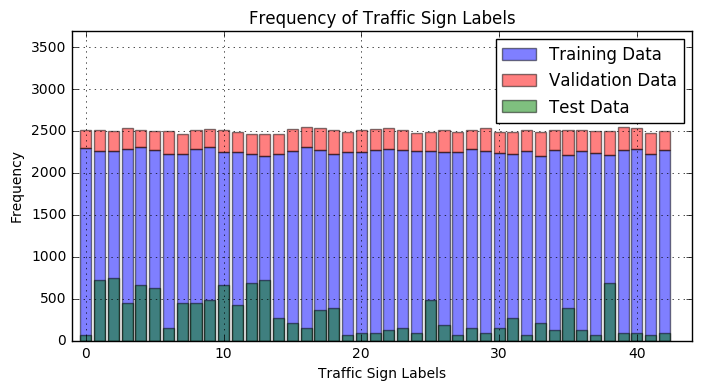

In [22]:
# Plot Frequencies of Training, Validation and TEst Datasets

freq_train = itemfreq(train_labels)[:,1]
freq_test = itemfreq(test_labels)[:,1]
freq_valid = itemfreq(valid_labels)[:,1]

def plot_freq_data(freq_train, freq_valid, freq_test):
    x = range(len(freq_train))
    
    fig = plt.figure(figsize=(8,4))
    
    p1= plt.bar(x, freq_train, align='center', alpha=0.5)
    p2 = plt.bar(x, freq_valid, align='center', alpha=0.5, color='r',
             bottom=freq_train)
    p3 = plt.bar(x, freq_test, align='center', alpha=0.5, color='g')
    plt.xlabel("Traffic Sign Labels")
    plt.ylabel("Frequency")
    plt.title("Frequency of Traffic Sign Labels")
    plt.grid(True)
    plt.legend((p1[0], p2[0], p3[0]), ('Training Data', 'Validation Data', 'Test Data'))
    
    axes = plt.gca()
    axes.set_xlim([-1,44])
    axes.set_ylim([0,3700])
#     plt.gcf().set_size_inches(8,4)
    plt.show()
    
plot_freq_data(freq_train, freq_valid, freq_test) 

In [23]:
#%% Flattening and One-Hot encoding
imgsize = X_train[0].shape[1]

#Flattening images
train_features = np.reshape(train_features,(len(train_features),imgsize*imgsize)).astype(np.float32)
test_features = np.reshape(test_features,(len(test_features),imgsize*imgsize)).astype(np.float32)
valid_features = np.reshape(valid_features,(len(valid_features),imgsize*imgsize)).astype(np.float32)

encoder = LabelBinarizer()
encoder.fit(train_labels)

train_labels = encoder.transform(train_labels).astype(np.float32)
test_labels = encoder.transform(test_labels).astype(np.float32)
valid_labels = encoder.transform(valid_labels).astype(np.float32)

### Write Data to Pickle File

In [24]:
# Dump the generate data to pickle file

pickle_file = './traffic-signs-data/traffic_signal.p'

if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


### Read Data From Pickle File

In [47]:
# Read the Pickle File

pickle_file = './traffic-signs-data/traffic_signal.p'

with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


### Helper functions to Plot Errors

The helper functions are written to plot image classification errors. 

In [48]:
# Plot images
#%% Adopted from the Hvass lab and modified
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

def plot_images(images, cls_true, rows, cols, cls_pred=None):

    img_shape = (imgsize, imgsize)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(rows, cols)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}\n Pred: {1}".format(cls_true[i], cls_pred[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()

In [49]:
#%% Plot example errors
#%% Adopted from the Hvass lab and modified
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

def plot_example_errors(images, cls_true, cls_pred, rows, cols):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    rc = rows*cols
    
    correct = (cls_true == cls_pred)
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images[incorrect][0:rc]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect][0:rc]

    # Get the true classes for those images.
    cls_true = cls_true[incorrect][0:rc]
    
    # Plot the first 9 images.
    plot_images(images, cls_true, rows, cols, cls_pred)

----

## Step 3: Design and Test a CNN Model Architecture

As the regular neural nets don’t scale well to full images, a convolutional neural network (CNN) is used to extract features and later classify traffic sign images. As the features are be non-linear, a single layer CNN won't capture it. Hence a two-layered architecture as shown in the depiciton figure is used. 

The details of the layers are as follows:   
- Layer 1: 64 kernels of (5 x 5) size -> ReLu -> Max Pooling (2 x 2) -> Dropout 
- Layer 2: 128 kernels of (5 x 5) size -> ReLu -> Max Pooling (2 x 2) -> Dropout
- Fully Connected Layer: 1024 nodes -> ReLu -> Dropout
- Softmax.

An Adam optimizer is used to minimize the loss function. Dropout is used in training model to avoid overfitting.

<img src="CNN.png">

In [50]:
# Define Tensorflow placeholders

features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

In [51]:
# Define feed dictionaries for train, validation, test data

train_feed_dict = {features: train_features, labels: train_labels, keep_prob: 1}
valid_feed_dict = {features: valid_features, labels: valid_labels, keep_prob: 1}
test_feed_dict = {features: test_features, labels: test_labels, keep_prob: 1}

A wrapper to define CNN is implemented.

In [52]:
#%% Adapted from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

# Create CNN model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, imgsize, imgsize, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    conv1 = tf.nn.dropout(conv1, dropout)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    conv2 = tf.nn.dropout(conv2, dropout)
    
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [53]:
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py
# Define CNN layer properties

ksize= 5                   # kernel size
layer1_kernels = 64        # Number of kernels in layer 1
layer2_kernels = 128       # Number of kernels in layer 2
layer_fc = 1024            # Number of Neurons in fully connected layer

# constants
meanv = 0.0
stddevv = 0.02

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.truncated_normal([ksize, ksize, 1, layer1_kernels], mean=meanv, stddev=stddevv, dtype=tf.float32)), # 128
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.truncated_normal([ksize, ksize, layer1_kernels, layer2_kernels], mean=meanv, stddev=stddevv, dtype=tf.float32)), # 256
    # fully connected, 8*8*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.truncated_normal([8*8*layer2_kernels, layer_fc], mean=meanv, stddev=stddevv, dtype=tf.float32)), # 1024
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal([layer_fc, n_classes], mean=meanv, stddev=stddevv, dtype=tf.float32))
}

biases = {
    'bc1': tf.Variable(tf.zeros([layer1_kernels])),
    'bc2': tf.Variable(tf.zeros([layer2_kernels])),
    'bd1': tf.Variable(tf.zeros([layer_fc])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

# Construct model
pred = conv_net(features, weights, biases, keep_prob)

#############################
# Linear Model
#weights = tf.Variable(tf.truncated_normal((n_input, n_classes)))
#biases = tf.Variable(tf.zeros(n_classes))
#logits = tf.matmul(features, weights) + biases
#logits = -np.amax(logits)
#pred = tf.nn.softmax(logits)
##############################

# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(pred, labels)
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(tf.clip_by_value(pred,1e-10,1.0)), reduction_indices=[1]))
loss = tf.reduce_mean(cross_entropy)

# Evaluate model
y_pred_cls = tf.argmax(pred,1)
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

softmax_pred = tf.nn.softmax(pred)
softmax_pred_top5 = tf.nn.top_k(softmax_pred, k=5, sorted=True)

In [54]:
# Tensorflow GPU configruation setup

config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'

### CNN Training

In [33]:
def model_training(epochs = 2, batch_size = 128, learning_rate = 0.001):
	# time
	start_time = time.time()

	optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

	# The accuracy measured against the validation set
	validation_accuracy = 0.0
	
	init = tf.global_variables_initializer()

	# Measurements use for graphing loss and accuracy
	log_batch_step = 50
	batches = []
	loss_batch = []
	train_acc_batch = []
	valid_acc_batch = []
	
	#######################################################
	with tf.Session(config = config) as session:
		session.run(init)
		
		batch_count = int(math.ceil(len(train_features)/batch_size))

		for epoch_i in range(epochs):
			print('Epoch {:>2}/{} '.format(epoch_i+1, epochs)+'#'*40)
			# Progress bar
#            batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
			batches_pbar = range(batch_count)

			# The training cycle
			for batch_i in batches_pbar:
				# Get a batch of training features and labels
				batch_index = np.random.choice(len(train_features),batch_size, replace=False)
				batch_features = train_features[batch_index]
				batch_labels = train_labels[batch_index]
			
				# Run optimizer and get loss
				_, lossi = session.run( [optimizer, loss], feed_dict={features: batch_features, labels: batch_labels, keep_prob: 0.5})

				# Log every 50 batches
				if not batch_i % log_batch_step:
					# Calculate Training and Validation accuracy
					training_accuracy = session.run(accuracy, feed_dict={features: batch_features, labels: batch_labels, keep_prob: 1.})
					validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
					print('Batch # = {:>4} : Loss : {:19.16f}, Training accuracy = {:f} : Validation accuracy = {:f}'.format(batch_i, lossi, training_accuracy, validation_accuracy))
					# Log batches
					previous_batch = batches[-1] if batches else 0
					batches.append(log_batch_step + previous_batch)
					loss_batch.append(lossi)
					train_acc_batch.append(training_accuracy)
					valid_acc_batch.append(validation_accuracy)

			# Check accuracy against Validation data
#            train_acc = session.run(accuracy, feed_dict=train_feed_dict)
			validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

	loss_plot = plt.subplot(211)
	loss_plot.set_title('Loss')
	loss_plot.plot(batches, loss_batch, 'g')
	loss_plot.set_xlim([batches[0], batches[-1]])
	acc_plot = plt.subplot(212)
	acc_plot.set_title('Accuracy')
	acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
	acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
	acc_plot.set_ylim([0, 1.0])
	acc_plot.set_xlim([batches[0], batches[-1]])
	acc_plot.legend(loc=4)
	plt.tight_layout()
	plt.show()
    
	print('Training accuracy = {:f} : Validation accuracy = {:f}'.format(training_accuracy, validation_accuracy))

	# end time
	end_time = time.time()
	time_delta = end_time - start_time
	print("Time usage : "+ str(timedelta(seconds=int(round(time_delta)))))        
    
	print('#'*80)

### Parameter Tuning

Now, it is time to train a CNN model. The parameters (learning_rate, epoch and batch_size) are tuned to pick the best combination of parameters.

>>>>>>>>> Model Training for learning_rate =  [0.5, 0.1, 0.01, 0.001, 0.0001]
>>>>>>>>>>>>>>>>>>>>> learning_rate =  0.5
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7629628181457520, Training accuracy = 0.054688 : Validation accuracy = 0.021812
Batch # =   50 : Loss :  3.8336503505706787, Training accuracy = 0.039062 : Validation accuracy = 0.023397
Batch # =  100 : Loss :  3.7861852645874023, Training accuracy = 0.031250 : Validation accuracy = 0.023770
Batch # =  150 : Loss :  3.8575949668884277, Training accuracy = 0.023438 : Validation accuracy = 0.022837
Batch # =  200 : Loss :  3.8411154747009277, Training accuracy = 0.023438 : Validation accuracy = 0.023210
Batch # =  250 : Loss :  3.7816100120544434, Training accuracy = 0.039062 : Validation accuracy = 0.023490
Batch # =  300 : Loss :  3.8207461833953857, Training accuracy = 0.000000 : Validation accuracy = 0.023397
Batch # =  350 : Loss :  3.8416342735290527, Training accuracy = 0.023438 : Va

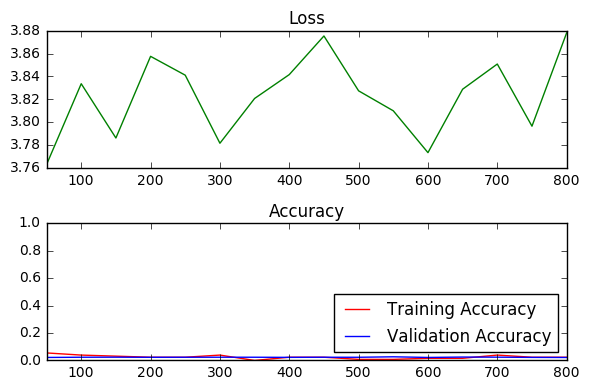

Training accuracy = 0.023438 : Validation accuracy = 0.022465
Time usage : 0:00:32
################################################################################
>>>>>>>>>>>>>>>>>>>>> learning_rate =  0.1
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7602481842041016, Training accuracy = 0.070312 : Validation accuracy = 0.021812
Batch # =   50 : Loss :  3.7516050338745117, Training accuracy = 0.023438 : Validation accuracy = 0.022558
Batch # =  100 : Loss :  3.7806668281555176, Training accuracy = 0.046875 : Validation accuracy = 0.023024
Batch # =  150 : Loss :  3.7803192138671875, Training accuracy = 0.015625 : Validation accuracy = 0.024515
Batch # =  200 : Loss :  3.7575392723083496, Training accuracy = 0.031250 : Validation accuracy = 0.024888
Batch # =  250 : Loss :  3.7653460502624512, Training accuracy = 0.023438 : Validation accuracy = 0.024515
Batch # =  300 : Loss :  3.7758188247680664, Training accuracy = 0.031250 : Validation accuracy = 0

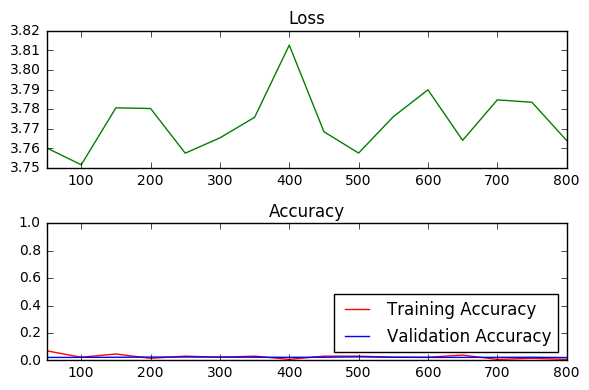

Training accuracy = 0.007812 : Validation accuracy = 0.023770
Time usage : 0:00:32
################################################################################
>>>>>>>>>>>>>>>>>>>>> learning_rate =  0.01
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7632250785827637, Training accuracy = 0.039062 : Validation accuracy = 0.021812
Batch # =   50 : Loss :  3.6925754547119141, Training accuracy = 0.054688 : Validation accuracy = 0.040082
Batch # =  100 : Loss :  3.5171484947204590, Training accuracy = 0.148438 : Validation accuracy = 0.109806
Batch # =  150 : Loss :  3.3755025863647461, Training accuracy = 0.132812 : Validation accuracy = 0.150820
Batch # =  200 : Loss :  3.0634837150573730, Training accuracy = 0.250000 : Validation accuracy = 0.294743
Batch # =  250 : Loss :  2.7781691551208496, Training accuracy = 0.414062 : Validation accuracy = 0.359060
Batch # =  300 : Loss :  2.6341865062713623, Training accuracy = 0.375000 : Validation accuracy = 

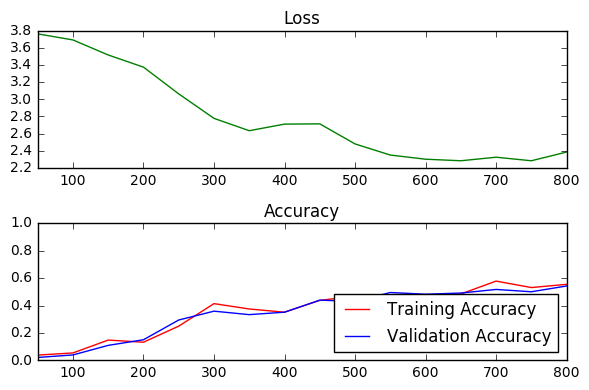

Training accuracy = 0.554688 : Validation accuracy = 0.536726
Time usage : 0:00:33
################################################################################
>>>>>>>>>>>>>>>>>>>>> learning_rate =  0.001
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7567687034606934, Training accuracy = 0.046875 : Validation accuracy = 0.023210
Batch # =   50 : Loss :  3.6708631515502930, Training accuracy = 0.070312 : Validation accuracy = 0.064224
Batch # =  100 : Loss :  3.1199061870574951, Training accuracy = 0.273438 : Validation accuracy = 0.224273
Batch # =  150 : Loss :  2.2814595699310303, Training accuracy = 0.453125 : Validation accuracy = 0.435496
Batch # =  200 : Loss :  1.7131057977676392, Training accuracy = 0.671875 : Validation accuracy = 0.572148
Batch # =  250 : Loss :  1.4700338840484619, Training accuracy = 0.734375 : Validation accuracy = 0.671234
Batch # =  300 : Loss :  1.2454280853271484, Training accuracy = 0.781250 : Validation accuracy =

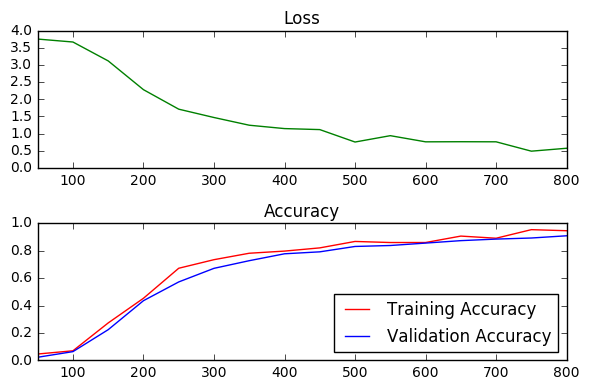

Training accuracy = 0.945312 : Validation accuracy = 0.900447
Time usage : 0:00:36
################################################################################
>>>>>>>>>>>>>>>>>>>>> learning_rate =  0.0001
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7669949531555176, Training accuracy = 0.007812 : Validation accuracy = 0.026846
Batch # =   50 : Loss :  3.7005858421325684, Training accuracy = 0.023438 : Validation accuracy = 0.032625
Batch # =  100 : Loss :  3.6946508884429932, Training accuracy = 0.070312 : Validation accuracy = 0.061428
Batch # =  150 : Loss :  3.6554188728332520, Training accuracy = 0.015625 : Validation accuracy = 0.059004
Batch # =  200 : Loss :  3.7028613090515137, Training accuracy = 0.062500 : Validation accuracy = 0.097502
Batch # =  250 : Loss :  3.4583749771118164, Training accuracy = 0.140625 : Validation accuracy = 0.147558
Batch # =  300 : Loss :  3.3536705970764160, Training accuracy = 0.203125 : Validation accuracy 

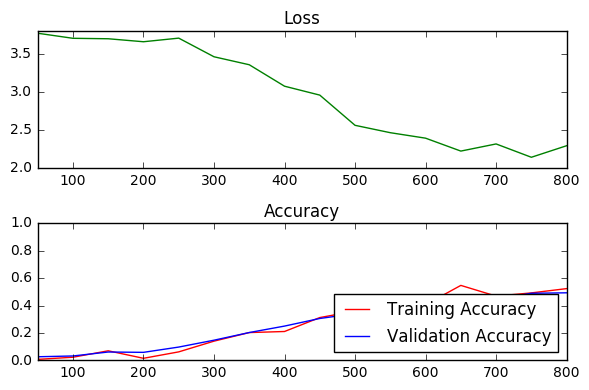

Training accuracy = 0.523438 : Validation accuracy = 0.492822
Time usage : 0:00:36
################################################################################


In [35]:
# Train the system 
# learning_rate parameter space 

learning_rate_list = [0.5, 0.1, 0.01, 0.001, 0.0001]
print('>>>>>>>>> Model Training for learning_rate = ', learning_rate_list)

for learning_rate in learning_rate_list:
    print('>>>>>>>>>>>>>>>>>>>>> learning_rate = ', learning_rate)
    model_training(epochs = 1, batch_size = 128, learning_rate = learning_rate)

>>>>>>>>> Model Training for batch_size =  [64, 128, 256]
>>>>>>>>>>>>>>>>>>>>> learning_rate =  64
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7573873996734619, Training accuracy = 0.062500 : Validation accuracy = 0.025354
Batch # =   50 : Loss :  3.6880292892456055, Training accuracy = 0.031250 : Validation accuracy = 0.034210
Batch # =  100 : Loss :  3.6937537193298340, Training accuracy = 0.062500 : Validation accuracy = 0.092655
Batch # =  150 : Loss :  3.1285498142242432, Training accuracy = 0.265625 : Validation accuracy = 0.216163
Batch # =  200 : Loss :  2.5804395675659180, Training accuracy = 0.359375 : Validation accuracy = 0.347502
Batch # =  250 : Loss :  2.4876332283020020, Training accuracy = 0.421875 : Validation accuracy = 0.473620
Batch # =  300 : Loss :  1.7220023870468140, Training accuracy = 0.656250 : Validation accuracy = 0.551640
Batch # =  350 : Loss :  1.8962922096252441, Training accuracy = 0.531250 : Validation accuracy = 0

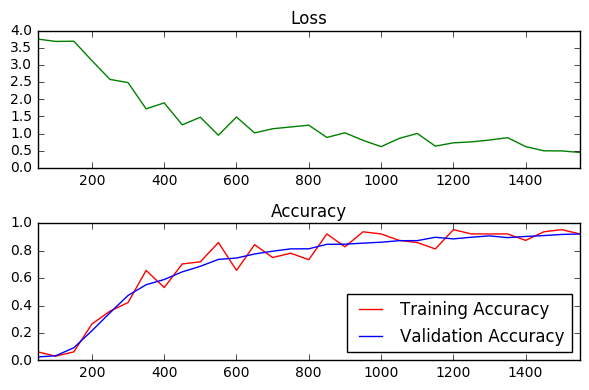

Training accuracy = 0.921875 : Validation accuracy = 0.914616
Time usage : 0:00:52
################################################################################
>>>>>>>>>>>>>>>>>>>>> learning_rate =  128
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7636954784393311, Training accuracy = 0.062500 : Validation accuracy = 0.023210
Batch # =   50 : Loss :  3.7573983669281006, Training accuracy = 0.054688 : Validation accuracy = 0.076529
Batch # =  100 : Loss :  2.9736995697021484, Training accuracy = 0.304688 : Validation accuracy = 0.236764
Batch # =  150 : Loss :  2.2418758869171143, Training accuracy = 0.453125 : Validation accuracy = 0.447520
Batch # =  200 : Loss :  1.6852269172668457, Training accuracy = 0.609375 : Validation accuracy = 0.584825
Batch # =  250 : Loss :  1.5781259536743164, Training accuracy = 0.703125 : Validation accuracy = 0.678971
Batch # =  300 : Loss :  1.0719647407531738, Training accuracy = 0.757812 : Validation accuracy = 0

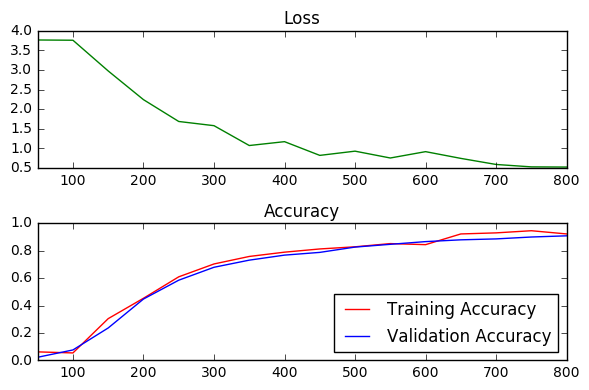

Training accuracy = 0.921875 : Validation accuracy = 0.903710
Time usage : 0:00:34
################################################################################
>>>>>>>>>>>>>>>>>>>>> learning_rate =  256
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7605543136596680, Training accuracy = 0.058594 : Validation accuracy = 0.028430
Batch # =   50 : Loss :  3.4855279922485352, Training accuracy = 0.093750 : Validation accuracy = 0.138236
Batch # =  100 : Loss :  2.3495221138000488, Training accuracy = 0.410156 : Validation accuracy = 0.426641
Batch # =  150 : Loss :  1.6042876243591309, Training accuracy = 0.609375 : Validation accuracy = 0.612416
Batch # =  200 : Loss :  1.3907594680786133, Training accuracy = 0.722656 : Validation accuracy = 0.704418
Batch # =  250 : Loss :  1.1666109561920166, Training accuracy = 0.789062 : Validation accuracy = 0.769482
Batch # =  300 : Loss :  0.9420495033264160, Training accuracy = 0.832031 : Validation accuracy = 0

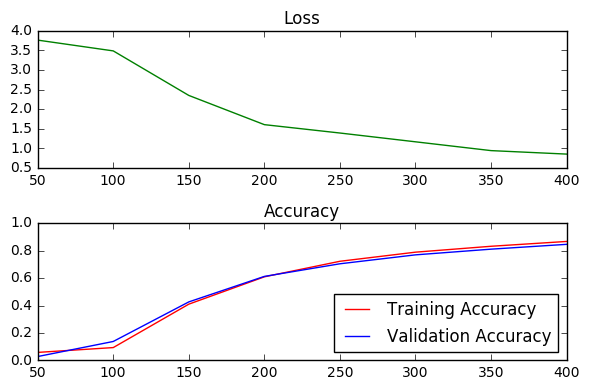

Training accuracy = 0.867188 : Validation accuracy = 0.856171
Time usage : 0:00:27
################################################################################


In [36]:
# Train the system 
# learning_rate parameter space 

batch_size_list = [64, 128, 256]
print('>>>>>>>>> Model Training for batch_size = ', batch_size_list)

for batch_size in batch_size_list:
    print('>>>>>>>>>>>>>>>>>>>>> learning_rate = ', batch_size)
    model_training(epochs = 1, batch_size = batch_size, learning_rate = 0.001)

>>>>>>>>> Model Training for epochs =  [1, 2, 3, 4, 5]
>>>>>>>>>>>>>>>>>>>>> Epoch =  1
Epoch  1/1 ########################################
Batch # =    0 : Loss :  3.7630639076232910, Training accuracy = 0.062500 : Validation accuracy = 0.023117
Batch # =   50 : Loss :  3.6531376838684082, Training accuracy = 0.062500 : Validation accuracy = 0.069911
Batch # =  100 : Loss :  2.8657159805297852, Training accuracy = 0.335938 : Validation accuracy = 0.247390
Batch # =  150 : Loss :  2.3123655319213867, Training accuracy = 0.468750 : Validation accuracy = 0.462808
Batch # =  200 : Loss :  1.5883324146270752, Training accuracy = 0.632812 : Validation accuracy = 0.580816
Batch # =  250 : Loss :  1.6284472942352295, Training accuracy = 0.632812 : Validation accuracy = 0.677666
Batch # =  300 : Loss :  1.3450977802276611, Training accuracy = 0.789062 : Validation accuracy = 0.740212
Batch # =  350 : Loss :  0.9473516941070557, Training accuracy = 0.867188 : Validation accuracy = 0.766499
Batc

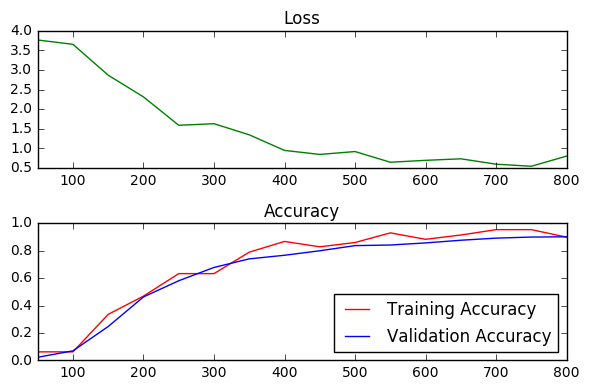

Training accuracy = 0.898438 : Validation accuracy = 0.906040
Time usage : 0:00:35
################################################################################
>>>>>>>>>>>>>>>>>>>>> Epoch =  2
Epoch  1/2 ########################################
Batch # =    0 : Loss :  3.7646884918212891, Training accuracy = 0.078125 : Validation accuracy = 0.026473
Batch # =   50 : Loss :  3.6164779663085938, Training accuracy = 0.117188 : Validation accuracy = 0.064970
Batch # =  100 : Loss :  3.0705714225769043, Training accuracy = 0.242188 : Validation accuracy = 0.234433
Batch # =  150 : Loss :  2.3484354019165039, Training accuracy = 0.500000 : Validation accuracy = 0.452461
Batch # =  200 : Loss :  1.7471573352813721, Training accuracy = 0.593750 : Validation accuracy = 0.593866
Batch # =  250 : Loss :  1.5600535869598389, Training accuracy = 0.679688 : Validation accuracy = 0.668624
Batch # =  300 : Loss :  1.0163383483886719, Training accuracy = 0.796875 : Validation accuracy = 0.721383
Ba

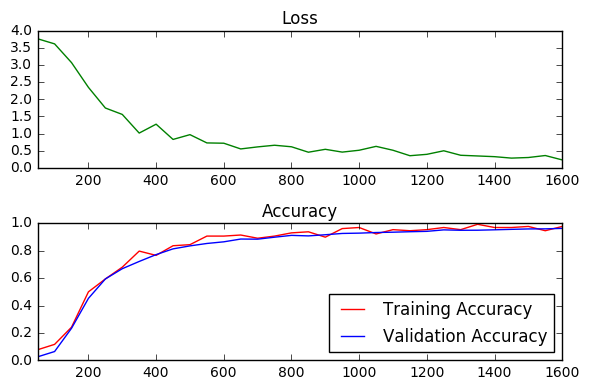

Training accuracy = 0.976562 : Validation accuracy = 0.964578
Time usage : 0:01:09
################################################################################
>>>>>>>>>>>>>>>>>>>>> Epoch =  3
Epoch  1/3 ########################################
Batch # =    0 : Loss :  3.7633516788482666, Training accuracy = 0.062500 : Validation accuracy = 0.020134
Batch # =   50 : Loss :  3.6805174350738525, Training accuracy = 0.085938 : Validation accuracy = 0.068512
Batch # =  100 : Loss :  2.7845282554626465, Training accuracy = 0.265625 : Validation accuracy = 0.253356
Batch # =  150 : Loss :  2.1112856864929199, Training accuracy = 0.492188 : Validation accuracy = 0.433165
Batch # =  200 : Loss :  2.0299892425537109, Training accuracy = 0.546875 : Validation accuracy = 0.570097
Batch # =  250 : Loss :  1.3647859096527100, Training accuracy = 0.703125 : Validation accuracy = 0.662099
Batch # =  300 : Loss :  1.1448287963867188, Training accuracy = 0.757812 : Validation accuracy = 0.712808
Ba

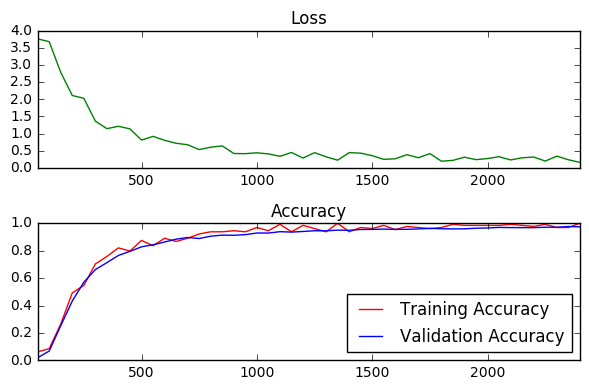

Training accuracy = 1.000000 : Validation accuracy = 0.972875
Time usage : 0:01:44
################################################################################
>>>>>>>>>>>>>>>>>>>>> Epoch =  4
Epoch  1/4 ########################################
Batch # =    0 : Loss :  3.7596797943115234, Training accuracy = 0.078125 : Validation accuracy = 0.025168
Batch # =   50 : Loss :  3.6780729293823242, Training accuracy = 0.101562 : Validation accuracy = 0.085477
Batch # =  100 : Loss :  2.8606054782867432, Training accuracy = 0.289062 : Validation accuracy = 0.287286
Batch # =  150 : Loss :  1.9081075191497803, Training accuracy = 0.523438 : Validation accuracy = 0.485925
Batch # =  200 : Loss :  1.6881783008575439, Training accuracy = 0.687500 : Validation accuracy = 0.597595
Batch # =  250 : Loss :  1.6059601306915283, Training accuracy = 0.640625 : Validation accuracy = 0.687360
Batch # =  300 : Loss :  1.0818175077438354, Training accuracy = 0.812500 : Validation accuracy = 0.717002
Ba

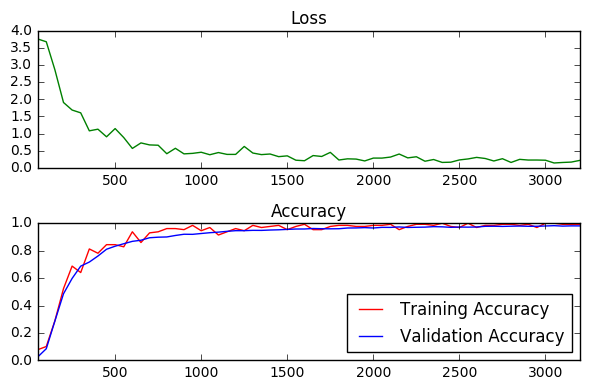

Training accuracy = 0.992188 : Validation accuracy = 0.979586
Time usage : 0:02:17
################################################################################
>>>>>>>>>>>>>>>>>>>>> Epoch =  5
Epoch  1/5 ########################################
Batch # =    0 : Loss :  3.7564482688903809, Training accuracy = 0.054688 : Validation accuracy = 0.021812
Batch # =   50 : Loss :  3.6174235343933105, Training accuracy = 0.109375 : Validation accuracy = 0.083240
Batch # =  100 : Loss :  2.9220466613769531, Training accuracy = 0.265625 : Validation accuracy = 0.238069
Batch # =  150 : Loss :  2.4198336601257324, Training accuracy = 0.429688 : Validation accuracy = 0.431208
Batch # =  200 : Loss :  1.8930081129074097, Training accuracy = 0.578125 : Validation accuracy = 0.558538
Batch # =  250 : Loss :  1.4974833726882935, Training accuracy = 0.671875 : Validation accuracy = 0.643177
Batch # =  300 : Loss :  1.3527483940124512, Training accuracy = 0.703125 : Validation accuracy = 0.721383
Ba

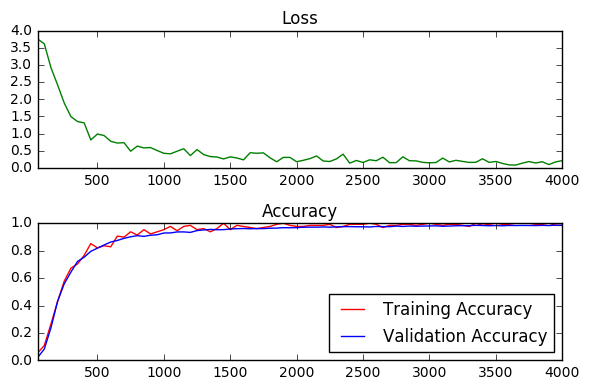

Training accuracy = 0.984375 : Validation accuracy = 0.984433
Time usage : 0:02:49
################################################################################


In [37]:
# Train the system 
# Epochs parameter space 

epochs_list = [1, 2, 3, 4, 5]
print('>>>>>>>>> Model Training for epochs = ', epochs_list)

for epochs in epochs_list:
    print('>>>>>>>>>>>>>>>>>>>>> Epoch = ', epochs)
    model_training(epochs = epochs, batch_size = 128, learning_rate = 0.001)

Based on the above studies, I selected the following parameters for testing sets to avoid overfitting.    
- epochs = 4 
- batch_size = 128   
- learning_rate = 0.001.  

The model is trained with the selected parameters and validation accuracy is calculated.

Epoch  1/4 ########################################
Batch # =    0 : Loss :  3.7584764957427979, Training accuracy = 0.054688 : Validation accuracy = 0.024888
Batch # =   50 : Loss :  3.6336197853088379, Training accuracy = 0.078125 : Validation accuracy = 0.059284
Batch # =  100 : Loss :  3.0265471935272217, Training accuracy = 0.234375 : Validation accuracy = 0.247670
Batch # =  150 : Loss :  2.1023225784301758, Training accuracy = 0.468750 : Validation accuracy = 0.455444
Batch # =  200 : Loss :  1.8535778522491455, Training accuracy = 0.554688 : Validation accuracy = 0.592748
Batch # =  250 : Loss :  1.4646797180175781, Training accuracy = 0.695312 : Validation accuracy = 0.672725
Batch # =  300 : Loss :  1.4651470184326172, Training accuracy = 0.742188 : Validation accuracy = 0.719798
Batch # =  350 : Loss :  1.2098798751831055, Training accuracy = 0.765625 : Validation accuracy = 0.747483
Batch # =  400 : Loss :  0.9477650523185730, Training accuracy = 0.859375 : Validation accur

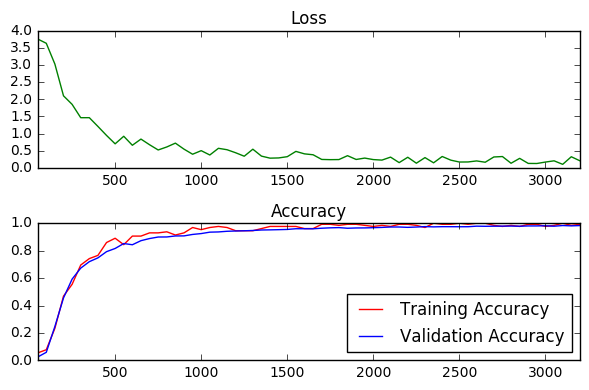

Training accuracy = 0.992188 : Validation accuracy = 0.982382
Time usage : 0:02:18
################################################################################


In [38]:
model_training(epochs = 4, batch_size = 128, learning_rate = 0.001)

The final training accuracy is ~ 99% and the validation accuracy is ~98%.

### CNN Model Testing on Test Dataset

In [15]:
def model_testing(epochs = 4, batch_size = 128, learning_rate = 0.001):
	
	# time
	start_time = time.time()

	optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
	# The accuracy measured against the test set
	test_accuracy = 0.0
	
	init = tf.global_variables_initializer()

	# Measurements use for graphing loss and accuracy
	log_batch_step = 50
	batches = []
	loss_batch = []
	train_acc_batch = []
	test_acc_batch = []
	
	#######################################################
	with tf.Session(config = config) as session:
		session.run(init)
		
		batch_count = int(math.ceil(len(train_features)/batch_size))

		for epoch_i in range(epochs):
			print('Epoch {:>2}/{} '.format(epoch_i+1, epochs)+'#'*40)
			# Progress bar
			batches_pbar = range(batch_count)

			# The training cycle
			for batch_i in batches_pbar:
				# Get a batch of training features and labels
				batch_index = np.random.choice(len(train_features),batch_size, replace=False)
				batch_features = train_features[batch_index]
				batch_labels = train_labels[batch_index]
			
				# Run optimizer and get loss
				_, lossi = session.run( [optimizer, loss], feed_dict={features: batch_features, labels: batch_labels, keep_prob: 0.5})

				# Log every 50 batches
				if not batch_i % log_batch_step:
					# Calculate Training and Validation accuracy
					training_accuracy = session.run(accuracy, feed_dict={features: batch_features, labels: batch_labels, keep_prob: 1.})
					test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
					print('Batch # = {:>4} : Loss : {:19.16f}, Training accuracy = {:f} : Test accuracy = {:f}'.format(batch_i, lossi, training_accuracy, test_accuracy))
					# Log batches
					previous_batch = batches[-1] if batches else 0
					batches.append(log_batch_step + previous_batch)
					loss_batch.append(lossi)
					train_acc_batch.append(training_accuracy)
					test_acc_batch.append(test_accuracy)

			# Check accuracy against Validation data
			test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)           
			y_pred = session.run(y_pred_cls, feed_dict=test_feed_dict)
			
			cm = tf.contrib.metrics.confusion_matrix(tf.argmax(test_labels, 1), y_pred, num_classes=n_classes, dtype=tf.int32).eval()
			
	loss_plot = plt.subplot(211)
	loss_plot.set_title('Loss')
	loss_plot.plot(batches, loss_batch, 'g')
	loss_plot.set_xlim([batches[0], batches[-1]])
	acc_plot = plt.subplot(212)
	acc_plot.set_title('Accuracy')
	acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
	acc_plot.plot(batches, test_acc_batch, 'b', label='Test Accuracy')
	acc_plot.set_ylim([0, 1.0])
	acc_plot.set_xlim([batches[0], batches[-1]])
	acc_plot.legend(loc=4)
	plt.tight_layout()
	plt.show()

	print('>>>>> Test accuracy = {:f}'.format(test_accuracy))
	print('Confusion Matrix : \n', cm)

	# end time
	end_time = time.time()
	time_delta = end_time - start_time
	print("Time usage : "+ str(timedelta(seconds=int(round(time_delta))))) 
	print('#'*80)
    
	return test_accuracy, y_pred, cm

>>>>>>>>> Model Testing 
Epoch  1/4 ########################################
Batch # =    0 : Loss :  3.7592422962188721, Training accuracy = 0.046875 : Test accuracy = 0.009501
Batch # =   50 : Loss :  3.6580352783203125, Training accuracy = 0.078125 : Test accuracy = 0.048852
Batch # =  100 : Loss :  3.1677501201629639, Training accuracy = 0.210938 : Test accuracy = 0.188044
Batch # =  150 : Loss :  2.3099513053894043, Training accuracy = 0.476562 : Test accuracy = 0.455820
Batch # =  200 : Loss :  1.7073459625244141, Training accuracy = 0.625000 : Test accuracy = 0.557245
Batch # =  250 : Loss :  1.5524237155914307, Training accuracy = 0.695312 : Test accuracy = 0.678227
Batch # =  300 : Loss :  1.7116169929504395, Training accuracy = 0.656250 : Test accuracy = 0.726366
Batch # =  350 : Loss :  1.2153507471084595, Training accuracy = 0.765625 : Test accuracy = 0.784482
Batch # =  400 : Loss :  0.8968414068222046, Training accuracy = 0.820312 : Test accuracy = 0.790341
Batch # =  450

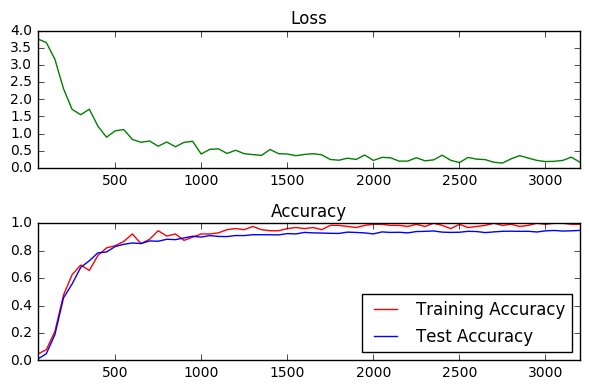

>>>>> Test accuracy = 0.944735
Confusion Matrix : 
 [[ 52   8   0 ...,   0   0   0]
 [ 10 699   3 ...,   0   0   0]
 [  0  13 700 ...,   0   0   0]
 ..., 
 [  0   3   0 ...,  68   0   0]
 [  0   0   0 ...,   0  60   0]
 [  0   0   0 ...,   0   0  90]]
Time usage : 0:02:30
################################################################################


In [16]:
# Testing the model
print('>>>>>>>>> Model Testing ')
test_accuracy, y_pred, cm = model_testing(epochs = 4, batch_size = 128, learning_rate = 0.001)

A test accuracy of ~94% is achieved.

Now let's plot some of the mis-classified images. 

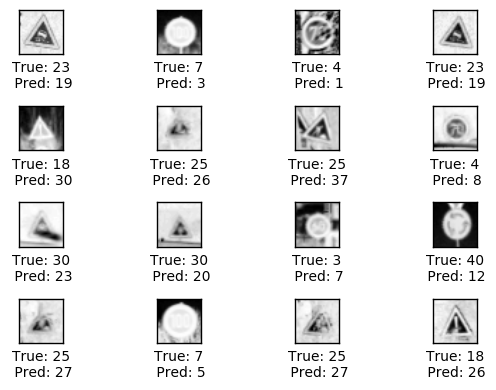

In [17]:
# Plot example errors in testing
images = test_features
 
cls_true = test_labels
cls_true = np.argmax(cls_true, 1)
cls_pred = y_pred

rows = 4
cols = 4

plot_example_errors(images, cls_true, cls_pred, rows, cols)

--------------
## Step 4: Testing CNN Model on New Images

A new data is genererated by extracting traffic signal images from [Gram Dataset](http://agamenon.tsc.uah.es/Investigacion/gram/traffic_signs.html) and Google Images. Nine images are saved in a directory and read. A following procedure is used to create a simple processing pipeline:   
- Images are read and resized to 32 x 32 pixel size
- Images are convered to Grayscale
- Images are then normalized
- Images are reshaped and labels are convered to one-hot encoded vector for further analysis.

In [55]:
#%% Read new dataset

# Iterate through the list of images
imagelist = ["newts/"+imgname for imgname in os.listdir("newts/")]

newts_features = np.array([np.zeros((imgsize,imgsize))])

for image in imagelist:
    if image.endswith(".png"):
        
        # Read and preprocess the image 
        image_original = mpimg.imread(image)
        img = (np.copy(image_original)*255).astype('uint8')
        croppedImage = cv2.resize(img, (imgsize, imgsize))
        gray = grayscale(croppedImage)
        nimg = normalize_image(gray)
        newts_features = np.concatenate((newts_features,[nimg]))
        
newts_features = np.delete(newts_features,0,0)
newts_labels = np.array([31, 20, 27, 40, 25, 0, 1, 14, 28])

newts_features = np.reshape(newts_features,(len(newts_features),imgsize*imgsize)).astype(np.float32)
newts_labels = encoder.transform(newts_labels).astype(np.float32)
print('Labels converted to one-hot encoded vector')

Labels converted to one-hot encoded vector


<table>
<tr>
    <td>
        Image
    </td>
    <td>
        Correct Label
    </td>
    <td>
        Comment
    </td>
    <td>
        Prediction Estimate
    </td>    
</tr>
<tr>
    <td>
        <img src='newts/new_img_7_animal.png' style="width:64px;height:64px;">
    </td>
    <td>
       31
    </td>
     <td>
        Wild animal crossing. Similar images occurs in the database.
    </td>
    <td>
        Easy
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_2_rightturn.png' style="width:64px;height:64px;">
    </td>
    <td>
        20
    </td>
     <td>
       Dangerous curve to the right. Similar images occurs in the database.
    </td>
    <td>
        Easy
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_8_walking.png' style="width:64px;height:64px;">
    </td>
    <td>
        27
    </td>
     <td>
       This is a pedestrian image taken from pixelated traffic signal. The person is moving right instead of left in the database. Due to pixelation, this is a difficult image to classify.
    </td>
    <td>
        Difficult
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_6_roundabout.png' style="width:64px;height:64px;">
    </td>
    <td>
        40
    </td>
     <td>
       Roundabout mandatory. Similar images occurs in the database.
    </td>
    <td>
        Easy
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_5_workahead.png' style="width:64px;height:64px;">
    </td>
    <td>
        25
    </td>
     <td>
      Road work. This image has yellow background in contrast to white one in the database. 
    </td>
    <td>
        Easy
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_9_unknown.png' style="width:64px;height:64px;">
    </td>
    <td>
        0
    </td>
     <td>
       This is a purposely miscalssified image. No such images exist in the database.
    </td>
    <td>
        Difficult
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_4_speed30.png' style="width:64px;height:64px;">
    </td>
    <td>
        1
    </td>
     <td>
      Speed limit (30km/h). Similar images occurs in the database.
    </td>
    <td>
        Easy
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_1_stop_14.png' style="width:64px;height:64px;">
    </td>
    <td>
        14
    </td>
     <td>
      Stop. The shadow on the image may make it difficult to classify
    </td>
    <td>
        Difficult
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_3_crossing.png' style="width:64px;height:64px;">
    </td>
    <td>
        28
    </td>
     <td>
      Children crossing. The image in the database is slightly different. This may make the classification difficult.
    </td>
    <td>
        Difficult
    </td>
</tr>
</table>

Here are the gray colored plots of images with their true labels.

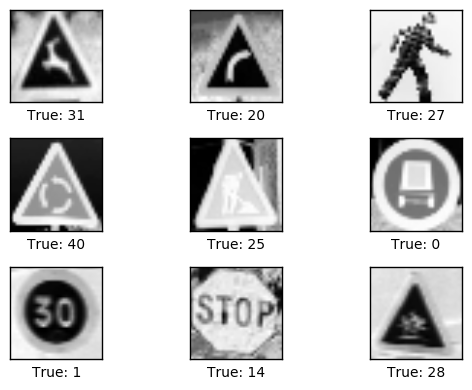

In [56]:
#%% plot images - new test dataset
rows = 3
cols = rows
rc = rows*cols

images = newts_features

cls_true = newts_labels
cls_true = np.argmax(cls_true, 1)

plot_images(images, cls_true, rows, cols)

In [57]:
# Feed dictionary
newts_feed_dict = {features: newts_features, labels: newts_labels, keep_prob: 1}

In [77]:
def model_testing_newdata(epochs = 4, batch_size = 128, learning_rate = 0.001):

	start_time = time.time()
	optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
	init = tf.global_variables_initializer()

	# Measurements use for graphing loss and accuracy
	log_batch_step = 50
	batches = []
	loss_batch = []
	train_acc_batch = []
	test_acc_batch = []
	#######################################################
	with tf.Session(config = config) as session:
		session.run(init)
		
		batch_count = int(math.ceil(len(train_features)/batch_size))

		for epoch_i in range(epochs):
			print('Epoch {:>2}/{} '.format(epoch_i+1, epochs)+'#'*40)
			# Progress bar
			batches_pbar = range(batch_count)

			# The training cycle
			for batch_i in batches_pbar:
				# Get a batch of training features and labels
				batch_index = np.random.choice(len(train_features),batch_size, replace=False)
				batch_features = train_features[batch_index]
				batch_labels = train_labels[batch_index]
			
				# Run optimizer and get loss
				_, lossi = session.run( [optimizer, loss], feed_dict={features: batch_features, labels: batch_labels, keep_prob: 0.5})
				
				# Log every 50 batches
				if not batch_i % log_batch_step:
					# Calculate Training and Validation accuracy
					training_accuracy = session.run(accuracy, feed_dict={features: batch_features, labels: batch_labels, keep_prob: 1.})
					test_accuracy = session.run(accuracy, feed_dict=newts_feed_dict)
					print('Batch # = {:>4} : Loss : {:19.16f}, Training accuracy = {:f} : Test accuracy = {:f}'.format(batch_i, lossi, training_accuracy, test_accuracy))
					# Log batches
					previous_batch = batches[-1] if batches else 0
					batches.append(log_batch_step + previous_batch)
					loss_batch.append(lossi)
					train_acc_batch.append(training_accuracy)
					test_acc_batch.append(test_accuracy)
                    
			# Check accuracy against Validation data
			newts_accurary = session.run(accuracy, feed_dict=newts_feed_dict)
			y_pred_newts = session.run(y_pred_cls, feed_dict=newts_feed_dict)
			softmax_newts = session.run(softmax_pred, feed_dict=newts_feed_dict)
			softmax_pred_top5_newts = session.run(softmax_pred_top5, feed_dict=newts_feed_dict)

	loss_plot = plt.subplot(211)
	loss_plot.set_title('Loss')
	loss_plot.plot(batches, loss_batch, 'g')
	loss_plot.set_xlim([batches[0], batches[-1]])
	acc_plot = plt.subplot(212)
	acc_plot.set_title('Accuracy')
	acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
	acc_plot.plot(batches, test_acc_batch, 'b', label='Test Accuracy')
	acc_plot.set_ylim([0, 1.0])
	acc_plot.set_xlim([batches[0], batches[-1]])
	acc_plot.legend(loc=4)
	plt.tight_layout()
	plt.show()
    
	print('Training accuracy = {:f} : Validation accuracy = {:f}'.format(training_accuracy, test_accuracy))
    
	# end time
	end_time = time.time()
	time_delta = end_time - start_time
	print("Time usage : "+ str(timedelta(seconds=int(round(time_delta)))))    
    
	return newts_accurary, y_pred_newts, softmax_newts, softmax_pred_top5_newts

>>>>>>>>> Model Testing on New Dataset
Epoch  1/3 ########################################
Batch # =    0 : Loss :  3.7587478160858154, Training accuracy = 0.054688 : Test accuracy = 0.111111
Batch # =   50 : Loss :  3.6195914745330811, Training accuracy = 0.101562 : Test accuracy = 0.000000
Batch # =  100 : Loss :  2.9087052345275879, Training accuracy = 0.273438 : Test accuracy = 0.111111
Batch # =  150 : Loss :  2.5577759742736816, Training accuracy = 0.406250 : Test accuracy = 0.222222
Batch # =  200 : Loss :  1.9896135330200195, Training accuracy = 0.570312 : Test accuracy = 0.222222
Batch # =  250 : Loss :  1.4309258460998535, Training accuracy = 0.718750 : Test accuracy = 0.222222
Batch # =  300 : Loss :  1.2989866733551025, Training accuracy = 0.734375 : Test accuracy = 0.333333
Batch # =  350 : Loss :  1.1927057504653931, Training accuracy = 0.828125 : Test accuracy = 0.333333
Batch # =  400 : Loss :  0.9091487526893616, Training accuracy = 0.812500 : Test accuracy = 0.333333


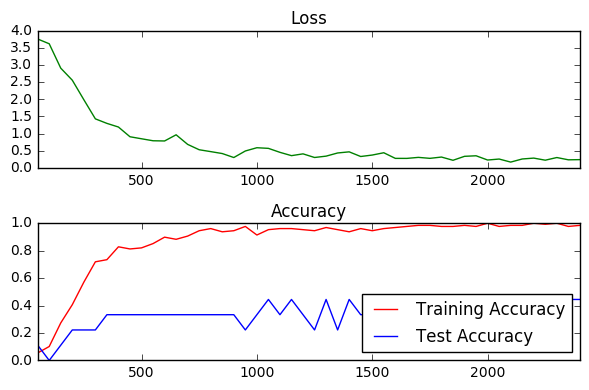

Training accuracy = 0.984375 : Validation accuracy = 0.444444
Time usage : 0:00:56


In [79]:
# Testing the model on new dataset
print('>>>>>>>>> Model Testing on New Dataset')
newts_accurary, y_pred_newts, softmax_newts, softmax_pred_top5_newts = model_testing_newdata(epochs = 3, batch_size = 128, learning_rate = 0.001)

The validation and test accuracy on the new test dataset are ~98% and ~44%, respectively. The deep learning model is not doing a good job in classifying the new dataset.

Let's plot the prediction.

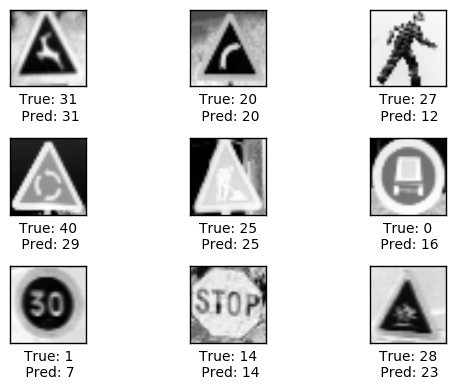

In [80]:
#%% plot images - new test dataset
rows = 3
cols = rows
rc = rows*cols

images = newts_features

cls_true = newts_labels
cls_true = np.argmax(cls_true, 1)

cls_pred = y_pred_newts

plot_images(images, cls_true, rows, cols, cls_pred)

### Calculating SoftMax Probabilities

Image #  0


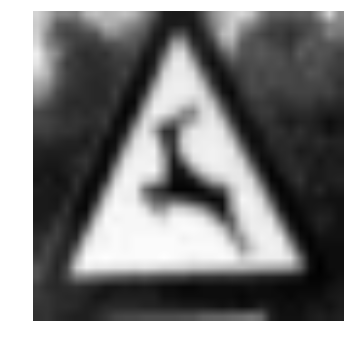

True class :  31
p_class	softmax_p
     31	  0.53355
     23	  0.27548
     21	  0.13178
     29	  0.02077
     19	  0.01745
################################################################################
Image #  1


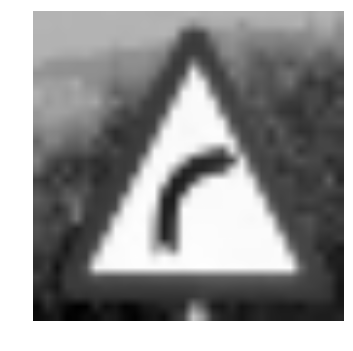

True class :  20
p_class	softmax_p
     20	  0.51163
     28	  0.33623
     27	  0.14861
     11	  0.00262
     22	  0.00087
################################################################################
Image #  2


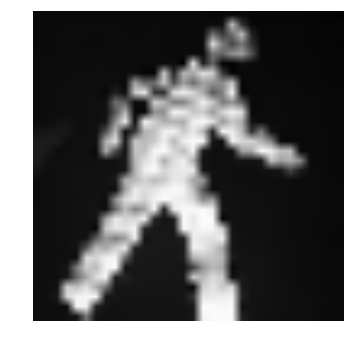

True class :  27
p_class	softmax_p
     12	  0.91318
     23	  0.02809
     38	  0.02593
     11	  0.02280
     21	  0.00287
################################################################################
Image #  3


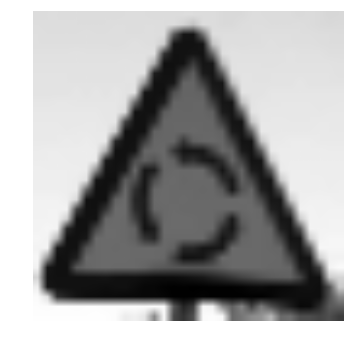

True class :  40
p_class	softmax_p
     29	  0.72725
     24	  0.10533
     22	  0.04631
     28	  0.03642
     23	  0.03245
################################################################################
Image #  4


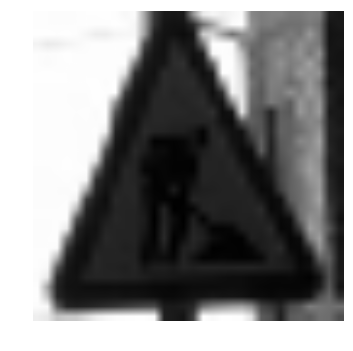

True class :  25
p_class	softmax_p
     25	  0.41014
     30	  0.35571
     11	  0.10470
     22	  0.05369
     28	  0.01360
################################################################################
Image #  5


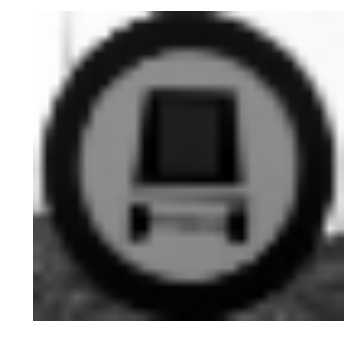

True class :  0
p_class	softmax_p
     16	  0.39616
     40	  0.29540
      5	  0.11453
      3	  0.03620
     10	  0.03338
################################################################################
Image #  6


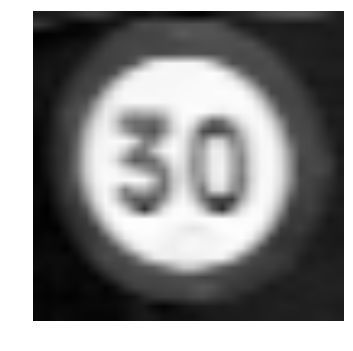

True class :  1
p_class	softmax_p
      7	  0.32374
      5	  0.20264
      8	  0.15464
      2	  0.13666
     10	  0.05983
################################################################################
Image #  7


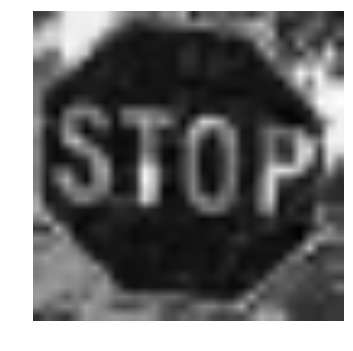

True class :  14
p_class	softmax_p
     14	  0.92253
     38	  0.06964
      4	  0.00188
      0	  0.00174
     34	  0.00155
################################################################################
Image #  8


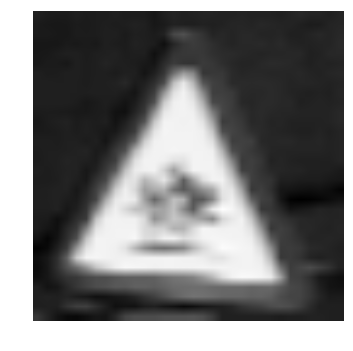

True class :  28
p_class	softmax_p
     23	  0.99964
     29	  0.00015
     28	  0.00012
     22	  0.00005
     19	  0.00003
################################################################################


In [81]:
# Print probabilities
for nimg in range(len(newts_labels)):
    print('Image # ',nimg)
    img = newts_features[nimg].reshape((imgsize, imgsize))
    plt.imshow(img, cmap='gray') 
    plt.axis('off')
    plt.show()
    print('True class : ',np.argmax(newts_labels[nimg]))
    print('p_class\tsoftmax_p')
    for nprob in range(len(softmax_pred_top5_newts[0][0])):
        print('{:>7}\t{:>9.5f}'.format(softmax_pred_top5_newts[1][nimg][nprob], softmax_pred_top5_newts[0][nimg][nprob]))
    print('#'*80)    

### Observations

<table>
<tr>
    <td>
        Image 
    </td>
    <td>
        Correct Label
    </td>
    <td>
        Predicted Labels (top 5) 
    </td>
    <td>
        Discussion
    </td>    
</tr>
<tr>
    <td>
        <img src='newts/new_img_7_animal.png' style="width:64px;height:64px;">
    </td>
    <td>
       31
    </td>
     <td>
        [31, 23, 21, 29, 19]
    </td>
    <td> 
        The classifier correctly classifed the image as class 31 with ~53.3% probability. 
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_2_rightturn.png' style="width:64px;height:64px;">
    </td>
    <td>
        20
    </td>
     <td>
       [20, 28, 27, 11, 22]
    </td>
    <td>
       The image is correctly classified as class 20 with ~51.1% confidence.
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_8_walking.png' style="width:64px;height:64px;">
    </td>
    <td>
        27
    </td>
     <td>
       [12, 23, 38, 11, 21]
    </td>
    <td>
        As estimate earlier, this is a difficult image to classify. The classifier does not predict the class in top 5 predictions.  
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_6_roundabout.png' style="width:64px;height:64px;">
    </td>
    <td>
        40
    </td>
     <td>
       [29, 24, 22, 28, 23]
    </td>
    <td>
       As per earlier estimate, this is an easy image to classify. However, the image is incorrectly classified as 29. In the top 5 predictions, the classifier does not predict the correct class.
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_5_workahead.png' style="width:64px;height:64px;">
    </td>
    <td>
        25
    </td>
     <td>
     [25, 30, 11, 22, 28] 
    </td>
    <td>
        The classifier correctly classifies the image with ~41% confidence.
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_9_unknown.png' style="width:64px;height:64px;">
    </td>
    <td>
        0
    </td>
     <td>
       [16, 40, 5, 3, 10]
    </td>
    <td>
        As per the earlier estimate, the image is not correctly classified. It is incorrectly classified as class 16.
    </td>
</tr>
<tr>
    <td>
       <img src='newts/new_img_4_speed30.png' style="width:64px;height:64px;">
    </td>
    <td>
        1
    </td>
     <td>
      [7, 5, 8, 2, 10]
    </td>
    <td>
        This prediction is strange. This is supposed to be easy classification. However, the classifier incorrectly predicts it as class 7. The classifier does not predict correct class in the top 5 predictions.
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_1_stop_14.png' style="width:64px;height:64px;">
    </td>
    <td>
        14
    </td>
     <td>
      [14, 38, 4, 0, 34]
    </td>
    <td>
        As per the earlier estimate, this is supposed to be a difficult image to classify. However, the classifer predicts the correct class with ~92.2% confidence.
    </td>
</tr>
<tr>
    <td>
        <img src='newts/new_img_3_crossing.png' style="width:64px;height:64px;">
    </td>
    <td>
        28
    </td>
     <td>
      [23, 29, 28, 22, 19]
    </td>
    <td>
        As per the earlier estimate, this is supposed to be a difficult image to classify. Indeed, it is difficult to classify. The classifier does not predict it correctly. The correct label 28 appears in the top 5 predictions, however with mere ~0.01% confidence.
    </td>
</tr>
</table>

It is interesting to note that the model does not classify the new images on par with the testing dataset accuracy.

-------
### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The answer is provided in the section =>    
    Step 2: Preprocess and Generate New Data    
        Preprocess images (grayscaling and normalization)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

The answer is provided in the section =>   
    Step 2: Preprocess and Generate New Data    
        Generate Additional Dataset

### Question 3

What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  

**Answer:**

The answer is provided in the section =>   
   Step 3: Design and Test a CNN Model Architecture

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The answer is provided in the section =>   
    Step 3: Design and Test a CNN Model Architecture  
        CNN Training

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

The CNN model is trained for different parameters such as learning_rate, epochs and batch_size. Parametic studies are conducted for each of these parameters and best ones are chosen to avoid overfitting or underfitting. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

The implemenation is described in   
    Step 4: Testing CNN Model on New Images

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

The answer is described in   
    Step 4: Testing CNN Model on New Images   
        Observations 

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

On live stream/captured images, the model will not perform on par with the testing dataset. The reason being the training/testing dataset is small. The model need to be build for a bigger datasets in different lighting conditions. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The implemenation is described in   
    Step 4: Testing CNN Model on New Images   
        Calculating SoftMax Probabilities

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

The pipelineis described in   
    Step 4: Testing CNN Model on New Images